<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Phase Curve of Solar System Objects</b> <br>
Contact authors: Christina Williams and Yumi Choi<br>
Last verified to run: <i>2023-08-18</i> <br>
LSST Science Piplines version: Weekly <i>2023_21</i> <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Investigate the derivation of phase curves for DP0.3 solar system objects and explore DP0.3-provided phase curve parameters. 

**Skills:** Use various TAP tables, including joining multiple tables. Derive and compare phase curves. Explore accuracy of the phase curve parameters as a function of observation quality.

**LSST Data Products:** TAP tables dp03_catalogs_10yr.SSObject, dp03_catalogs_10yr.MPCORB, dp03_catalogs_10yr.DiaSource, dp03_catalogs_10yr.SSSource

**Packages:** numpy, scipy, pandas, matplotlib, seaborn, lsst.rsp

**Credit:**
Inspired by a jupyter notebook developed by Queen's University Belfast Planet Lab (including Brian Rogers, Niall McElroy, and Meg Schwamb). Standalone functions for phase curve computing were developed by Pedro Bernardinelli. References: <a href="https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract">Muinonen et al. (2010)</a> and <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a> Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:** Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

In [ ]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

## 1. Introduction

This notebook explores the properties of solar system bodies in the DP0.3 dataset by using the science example of constructing and exploring their phase curves. 

The DP0.3 catalogs contain both real and simulated Solar System objects (including asteroids, near-earth objects, Trojans, trans-Neptunian objects, comets). In the real survey, these objects will change position between each Rubin image. The DP0.3 catalogs simulate the measurements of object movements between images, and these can be used to estimate their intrinsic properties and orbital parameters. An important way to characterize intrinsic properties of a solar system object is by measuring its "phase curve", which is the object brightness as a function of its "solar phase angle" (the angle made between the line of sight from the object to the sun, and the line of sight from the object to earth; see diagram at <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a>)

In order to reveal the intrinsic properties of the asteroid (such as its surface properties and albedo; and as a result helps determine its class of solar system body) we first must turn apparent magnitudes as a function of time (what is measured by LSST data) into "reduced magnitude", which takes into account the relative distances between the asteroid and the Sun/Earth (heliocentric/topocentric distances) at each observation. Reduced magnitude is normalized such that it is the brightness of an asteroid as if it is observed at 1 astronomical unit (au) from both the Sun and the Earth. Note that rotation curves or complex geometry of solar system objects are not included in DP0.3 simulations. Thus, any changes over time in an object’s apparent magnitude are due only to changes in its distance and phase angle. Phase curves can be constructed for each filters.

Modeling the phase curve (reduced magnitude $H(α)$ as a function of phase angle $α$) enables measurement of the absolute magnitude, $H$, defined as the brightness at 0 phase angle. The functional form can depend on the data quality and type of object targeted. In this tutorial, we will mention three functional forms that are relevant for understanding the DP0.3 data products. These are the `HG_model`, `HG1G2_model`, and `HG12_model`. The `HG_model` is the simplest model, and has the form:

$$H(α)=H−2.5log_{10}[(1−G)Φ_1(α)+GΦ_2(α)],$$

where $Φ_n$ are basis functions (which allow for one to model non-linearity in the data, but maintain linearity in the fitted parameters). $Φ_n$ are normalized to unity at α=0 deg. This model provides a best fit for the slope parameter $G$ (from which surface properties can then be derived) and the absolute magnitude $H$. $H$(α) is the reduced magnitude at a given phase angle α if measured at 1 au away from both earth and from the Sun (i.e. unit tropocentric and heliocentric distance). The `HG_model` $G$ and $H$ values are stored in the `dp03_catalogs_10yr.MPCORB` table. For further info on the `HG_model`, see [Bowell et al. 1989](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B/abstract). 

To better accommodate various observational effects (e.g., photometric quality, incomplete phase angle sampling) the more sophisticated `HG1G2_model` (a linear three-parameter function) and its nonlinear two-parameter version `HG12_model` were developed (see [Muinonen et al. 2010](https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract)). The `HG1G2_model` has the form

$$H(α)=H−2.5log_{10}[G_1Φ_1(α)+G_2Φ_2(α) + (1-G_1-G_2)Φ3(α)],$$

which now has three free parameters, $H$, $G_1$ and $G_2$. However, a third representation, the `HG12_model`, is generally very effective for deriving reliable values of absolute magnitude when the phase angle sampling is not optimal (e.g., poor phase angle coverage at a range of phase anlge). Thus, the LSST data products will compute estimated parameters of the `HG12_model` and this will be the focus of this tutorial. The `HG12_model` expresses the $G_1$ and $G_2$ parameters as a piecewise linear function of a single parameter, $G_{12}$, 

for $G_{12}$ > 0.2
$$G_1 = 0.9529\times G_{12} + 0.02162$$
$$G_2 = -0.6125\times G_{12} + 0.5572$$
for $G_{12}$ < 0.2
$$G_1 = 0.7527\times G_{12} + 0.06164$$
$$G_2 = -0.9612\times G_{12} + 0.6270$$

In this notebook we will demonstrate how to plot the phase curve of solar system bodies using the DP0.3 simulated catalogs. In Section 2 we will plot and compare the phase curves for three different types of objects at different orbital radii from the sun, and compare the data to the LSST pipeline measured phase curve parameters, H, and G12. In Section 3, we will aggregate the phase curve fits for a number of solar system bodies in DP0.3 and study how the quality of the fit depends on LSST observations (which additionally provides some insight into expectations for real LSST data).

### 1.1 Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing, and model fitting.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The [seaborn](https://seaborn.pydata.org/) package provides statistical data visualization with aesthetic and informative graphics.


In [2]:
# general python packages
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns

# LSST package for TAP queries
from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

#### 1.2.1 Set up some plotting defaults:

In [3]:
plt.style.use('tableau-colorblind10')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 12}
plt.rcParams.update(params)

To supress NumPy RuntimeWarning

In [4]:
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### 1.2.2 Define functions

Define a function to convert a given perihelion distance (`q`) and eccentricity (`e`) to an orbital semi-major axis (`a`). Their relationship is defined by q = a(1-e).

In [5]:
def calc_semimajor_axis(q, e):
    """
    Given a perihelion distance and orbital eccentricity,
    calculate the semi-major axis of the orbit.

    Parameters
    ----------
    q: ndarray
        Distance at perihelion, in au.
    e: ndarray
        Orbital eccentricity.

    Returns
    -------
    a: ndarray
        Semi-major axis of the orbit, in au.
        q = a(1-e), so a = q/(1-e)
    """

    return q / (1.0 - e)

The constants used to define the basis functions are pre-defined below with values taken from `sbpy` (https://sbpy.org).

In [6]:
alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2,
            3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2,
            1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1,
            1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp,
                    bc_type=((1, phi_1_derivs[0]), (1, phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp,
                    bc_type=((1, phi_2_derivs[0]), (1, phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp,
                    bc_type=((1, phi_3_derivs[0]), (1, phi_3_derivs[1])))

Define a function to compute `HG1G2_model` phase curve for a given set of paramters.

In [7]:
def HG1G2_model(phase, params):
    """
    Compute HG1G2 model phase curve for a given set
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    phi_1_ev = phi_1(phase)
    phi_2_ev = phi_2(phase)
    phi_3_ev = phi_3(phase)

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6 * phase[msk]/np.pi
    phi_2_ev[msk] = 1-9 * phase[msk]/(5 * np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev
                                      + params[2] * phi_2_ev
                                      + (1-params[1]-params[2]) * phi_3_ev)

Define a function to compute `HG12_model` phase curve for a given set of paramters.

In [8]:
def HG12_model(phase, params):
    """
    Compute HG12 model phase curve for a given set
    of parameters. This is a 2-parameter, simplified version
    of HG1G2 model, which is useful when phaseangle coverage is shorter.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

## 2. Plot the phase curve of a DP0.3 main belt asteroid

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [9]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Querying the DP0.3 SSObject and MPCORB catalogs

To plot an object's phase curve, we will need its apparent magnitudes & uncertainties across a range of observation times. Additionally, we need the phase angles of the object at those observation times, topocentric ($d_t$) and heliocentric ($d_h$) distances.

To define those mock observations of solar system objects, the DP0.3 model uses the `HG_model` form of the phase curve to predict the observed parameters (apparent magnitude) for each object. These "truth" values are defined in the MPCORB table as `mpcH` (intrinsic absolute magnitude in $V$ band) and `mpcG` (intrinsic slope). For the purposes of DP0.3, the intrinsic slope, `mpcG`, for all objects have a constant value of 0.15.

In the ssObjectTable, the LSST data products contain the fitted phase curve parameters based on the mock observations using the `HG12_model` (i.e., the fitted absolute magnitude `H` and slope parameter `G12` based on mock observations in $griz$ bands). Note that the value of `G12` slope will differ from `G` owing to the difference in functional form (see Section 1.2). The explanation for the absence of $u$ and $y$ bands in DP0.3 catalogs can be found <a href="https://dp0-3.lsst.io/data-products-dp0-3/data-simulation-dp0-3.html">here</a>.

We limit our query and select sources with a large number of observations that likely have good phase curve fits (in the ssObject table, this is `numObs` > 500) and with perihelion distance of less than 50 au (in the MPCORB table, `q` < 50), and then further narrow down our sample to focus on Main Belt asteroids and Trans-Neptunian Obects (TNOs) for this tutorial.  

We call the table returned by this query "unique" since it contains the IDs of unique solar system objects. Each object has mulptiple individual observations in each filter in LSST. 

In [10]:
nobs_thrh = '500'  
q_thrh = '50' 

In [11]:
query = """
SELECT
    mpc.ssObjectId, mpc.e, mpc.q, mpc.mpcG, mpc.mpcH,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err, sso.g_H_gG12_Cov, sso.g_Ndata, 
    sso.r_H, sso.r_Herr, sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov, sso.r_Ndata,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov, sso.i_Ndata, 
    sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err, sso.z_H_zG12_Cov, sso.z_Ndata
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs > {} AND mpc.q < {} ORDER by sso.ssObjectId
""".format(nobs_thrh, q_thrh)

df_uniqueObj = service.search(query).to_table()
df_uniqueObj

ssObjectId,e,q,mpcG,mpcH,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,g_Ndata,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,r_Ndata,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,i_Ndata,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov,z_Ndata
,,AU,,mag,d,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,,mag,mag,mag,mag,mag2,
int64,float64,float64,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32
-9222537907249304995,0.09660125473857706,2.2310128288283435,0.15,16.87,3143.7522,597,17.597746,0.002525589,0.5242287,0.016807392,2.8549612e-05,88,16.948742,0.0013476519,0.5429285,0.009638161,6.5757463e-06,188,16.747356,0.001662906,0.56159574,0.011460487,1.0805579e-05,179,16.799604,0.0033639513,0.6487688,0.027501844,5.7824313e-05,142
-9222483995821535577,0.29424069155468396,1.9362316683839091,0.15,17.17,3444.6194,572,17.892378,0.0030011362,0.5356499,0.016541408,3.551611e-05,86,17.25339,0.0013654836,0.51221377,0.010589452,6.6943853e-06,191,17.05174,0.0016929659,0.5182046,0.011280265,8.484092e-06,217,17.089748,0.0033140434,0.6069613,0.021974305,3.2934964e-05,78
-9221971933016733299,0.0976291375766725,2.888555675946908,0.15,18.0,2723.822,746,18.664347,0.055800155,0.347244,0.26160657,0.01430974,130,18.057875,0.029942885,0.46435815,0.14517778,0.004253509,295,17.961935,0.04835261,0.95906764,0.2541824,0.012122336,263,18.107779,0.13473842,1.5907454,0.7479739,0.098877385,58
-9220720406380870790,0.09512147704513033,1.9953585274612224,0.15,19.15,3222.984,665,19.904749,0.013439648,0.55585736,0.06074769,0.0007887325,111,19.22779,0.005833795,0.45027962,0.025766844,0.00014212134,256,19.050268,0.008084762,0.52834284,0.036148608,0.00027824502,244,19.075455,0.020713877,0.37634012,0.12822846,0.0018105556,54
-9220640479871465694,0.17976881698947061,2.147036588246449,0.15,18.29,2953.7966,811,19.013039,0.010362307,0.5813877,0.06650098,0.0002801186,119,18.35616,0.0056017186,0.5664521,0.03747131,8.552278e-05,361,18.16207,0.007582653,0.61351573,0.047324393,0.00017941432,275,18.1833,0.026288837,0.5392801,0.13970537,0.002663592,56
-9219923979471220159,0.021547772180767175,2.968645440688216,0.15,17.68,3555.268,538,18.22535,0.023752734,0.5783812,0.110554166,0.002525823,61,17.738914,0.010536464,0.51451194,0.051529925,0.00049941335,171,17.62861,0.016380973,0.58015823,0.07938024,0.0012189694,156,17.649204,0.032969635,0.7496997,0.15871492,0.0050237435,150
-9219795059799915702,0.12830834445954734,2.4352345152946997,0.15,16.83,3292.9883,621,17.380877,0.0051205107,0.5690084,0.025859954,0.00012237582,93,16.90583,0.0027816081,0.5631939,0.013792672,3.3815748e-05,187,16.78359,0.0038919214,0.5369547,0.019594172,6.824646e-05,177,16.78361,0.0076499204,0.5892782,0.03633772,0.00025940555,164
-9219794082883151426,0.038080548193470024,3.075101400122943,0.15,17.3,3605.8987,602,17.83845,0.008112962,0.5285556,0.062530726,0.0002829372,84,17.376654,0.005329876,0.5935142,0.037313636,0.00012812475,223,17.259592,0.0070621558,0.5969032,0.050179094,0.00021485357,197,17.253756,0.020202471,0.56551677,0.12664917,0.0020194082,98


### 2.3 Identify Main Belt and Outer Belt asteroids, and TNOs

Following the previous DP0.3 tutorial notebook 02 on the Main Belt Asteroids and notebook 03 on Trans-Neptunian Objects (TNOs), in this Section we show an example of how to plot an observed phase curve for a few types of solar system bodies in the DP0.3 dataset. Then, we will plot the best-fit phase curve model (defined in Section 1.2) that is generated by the LSST pipeline and stored in the SSObject table. To identify our Main Belt sample, we first calculate the semi-major axis (`a`) of each object's orbit. We then select several classes of object, based on their semi-major axes: Main Belt asteroids residing in inner main belt (2.0 < `a` < 2.8 au); asteroids in the outer belt (5 < `a` < 7 au; CONFIRM NAME), and finally Trans-Neptunian Objects (TNO) which are at `a` > 30 au. We further limit our sample to the asteroids with `numbObs` > 2000, to focus on objects with many individual observations to define its phase curve (for more information on empirical properties that influence phase curve fitting, see Section 3 and the followup tutorial notebook 03b).  

In [18]:
a = calc_semimajor_axis(df_uniqueObj['q'], df_uniqueObj['e'])

#main_belt = (a > 2.0) & (a < 3.25)
main_belt = (a > 2.0) & (a < 2.8)
good_main_belt = (df_uniqueObj['numObs'] > 2000) & main_belt

outer_belt = (a > 5) & (a < 6)
good_outer_belt = (df_uniqueObj['numObs'] > 2000) & outer_belt

TNO = (a > 30)
good_TNO =  (df_uniqueObj['numObs'] > 2000) & TNO

print('There are %d good Main Belt asteroids in this sample!' % len(a[good_main_belt]))
print('There are %d good outer Belt asteroids in this sample!' % len(a[good_outer_belt]))
print('There are %d TNOs in this sample!' % len(a[good_TNO]))

# combine together to use in the search query
good_all = good_main_belt+good_outer_belt+good_TNO

There are 111 good Main Belt asteroids in this sample!
There are 124 good outer Belt asteroids in this sample!
There are 38 TNOs in this sample!


First, lets visualize the orbital distances of our samples relative to eachother. This plot shows the distributions of the semi-major axis `a` for the all unique objects in our 3 samples.

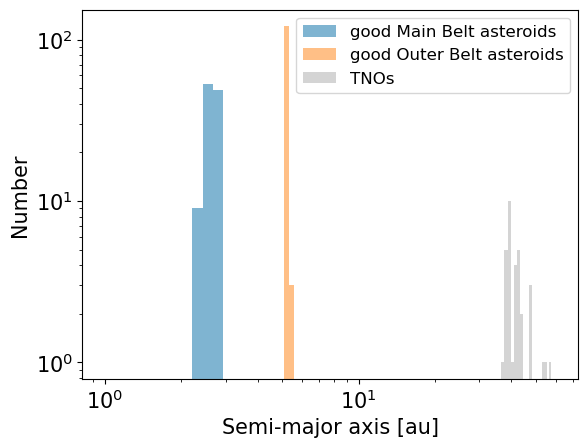

In [19]:
#h = plt.hist(a, bins=100, range=(1,50), histtype='step', density=True, label='all unique objects')
#h = plt.hist(a[good_main_belt], bins=50, range=(1,60), density=True, label='good Main Belt asteroids')
#h = plt.hist(a, bins=50, range=(1,50), histtype='step',  label='all unique objects')
h = plt.hist(a[good_main_belt], bins=25, range=(1,7), label='good Main Belt asteroids',alpha=.5)
h = plt.hist(a[good_outer_belt], bins=25, range=(1,7), label='good Outer Belt asteroids',alpha=.5)
h = plt.hist(a[good_TNO], bins=50, range=(1,60), label='TNOs',alpha=.5)

plt.xlabel('Semi-major axis [au]')
#plt.ylabel('Probability density')
plt.ylabel('Number')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### 2.3 Identify individual mock observations of the solar system bodies in DP0.3 DiaSource and SSSource catalogs 

While there are unique solar system objects in the `ssObject` and `MPCORB` tables, these objects will be observed many times over the full LSST survey. Individual observations of each unique object in each filter are recorded in the `SSSource` and `diaSource` tables. Below, we query these tables to obtain all of the individual observed time series data (we call `df_indivObs`) for the good solar system bodies selected above. This query usually takes ~30 sec.

In [20]:
query = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
""".format(tuple(df_uniqueObj['ssObjectId'][good_all]))

df_indivObs = service.search(query).to_table()
df_indivObs

ssObjectId,diaSourceId,mag,magErr,band,midPointMjdTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9217466392671047318,5074726492115737,20.055,0.012,r,61021.35247,17.301477,2.711414,3.1537251
-9217466392671047318,19481485662802488,19.669,0.007,i,61033.2511,15.801364,2.5499394,3.1503248
-9217466392671047318,39913165364548592,20.21,0.009,r,61010.34128,18.036163,2.8695178,3.1563327
-9217466392671047318,48327202766987632,19.45,0.01,z,61049.34712,12.501292,2.3604758,3.14477
-9217466392671047318,48371439483286632,19.711,0.008,i,61031.33981,16.094881,2.5749133,3.1509116
-9217466392671047318,62341640397910521,20.195,0.008,g,61051.17905,12.03446,2.3417952,3.144068
-9217466392671047318,73744426738833766,20.075,0.016,i,61005.35388,18.184,2.9424236,3.1573431
-9217466392671047318,75023334125204409,20.044,0.014,r,61021.3483,17.301888,2.711473,3.1537263


As a sanity check, here we confirm that the number of unique objects in `df_indivObs` is identical to that of the "good" asteroids in `df_uniqueObj`, as they should be.

In [ ]:
assert len(df_uniqueObj[good_all]) == len(np.unique(df_indivObs['ssObjectId']))

### 2.4 Plot the phase curve for a unique Main Belt asteroid

To plot the phase curve, we first must compute the reduced magnitude $H(\alpha)$ for each observation in each filter ($griz$ for DP0.3), and add it as a column to the `df_indivObs` table we produced of individual observations. The reduced magnitude $H(\alpha)$ as mentioned in Introduction is the normalized apparent magnitude of an asteroid as if it is observed at 1 au from both the Sun and the Earth as a function of phase angle $\alpha$, once accounting for the relative distances between the asteroid, and both sun and earth:

$$H(α) = m−5log_{10}(d_t\times\,d_h),$$

where $m$ is the apparent magnitude, and $d_t$ and $d_h$ are the topocentric and heliocentric distances of the object at the time of each observation. 

Note that the phase curves of solar system objects vary by observed filter, due to a combination of reflectivity of the surface and the intrinsic solar spectrum. For reference, to define the intrinsic absolute magnitude in DP0.3, the wavelength used to input the intrinsic absolute magnitude is in the $V$ band. Thus, one should not expect the absolute magnitude from any one filter to line up with the "truth" absolute magnitude, since none of the LSST filters include $V$ band. The conversion between each of the LSST filters and $V$ are documented for solar system bodies, and can be found here: https://github.com/lsst/dp0-3_lsst_io/blob/main/data-products-dp0-3/data-simulation-dp0-3.rst. 

In [21]:
thdist = df_indivObs['topocentricDist']*df_indivObs['heliocentricDist']
reduced_mag = df_indivObs['mag'] - 5.0*np.log10(thdist)

df_indivObs.add_column(reduced_mag, name='reducedMag')

Now, we will plot example phase curves in all available filters (in DP0.3) $g$,$r$,$i$,$z$ for a single object referenced by its ssObjectId, which we call `sId`. (You can explore different objects by changing the `iObj` index to retrieve different sources). Below you will see that the reduced magnitude and phase curve of the source are offset from each other in each filter, reflecting the variation in brightness of asteroids in different filters. 

You can pick an integer number between 0 and len(df_uniqueObj[good_main_belt])-1 for `iObj` below to explore other objects.

We also use the function defined in Section 1 for `HG12_model` in order to visualize the LSST pipeline phase curve fitting (dashed line). This demonstrates how absolute magnitude `H` is determined in the LSST data products.

Text(0.5, 1.0, 'Main Belt Asteroid')

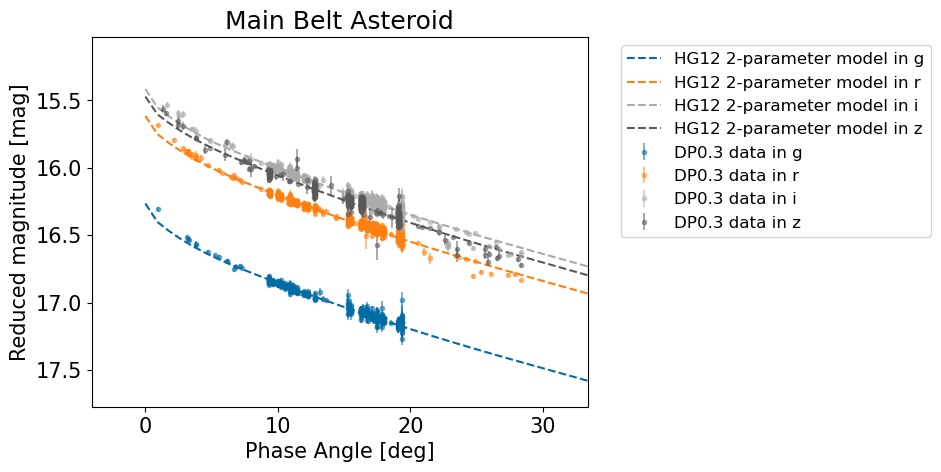

In [31]:
iObj = 1
sId = df_uniqueObj['ssObjectId'][good_main_belt][iObj]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)
filts = ['g', 'r', 'i', 'z']


for i, ifilt in enumerate(filts):
    idx = df_tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='.', color=colors[i],
                 alpha=0.5, label='DP0.3 data in %s' % ifilt)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj],
                           df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj]])
    plt.plot(phases, HG12_mag, color=colors[i], linestyle='--',
             label='HG12 2-parameter model in %s' % ifilt)


plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('Main Belt Asteroid')



Below, we now compare the phase curve of the 3 populations we selected based on orbital semi-major axis earlier: the main belt asteroid again, with the more distant populations in the outer belt and the TNOs. The same color scheme is used as the cell above. This cell must be executed after running the above cell first.

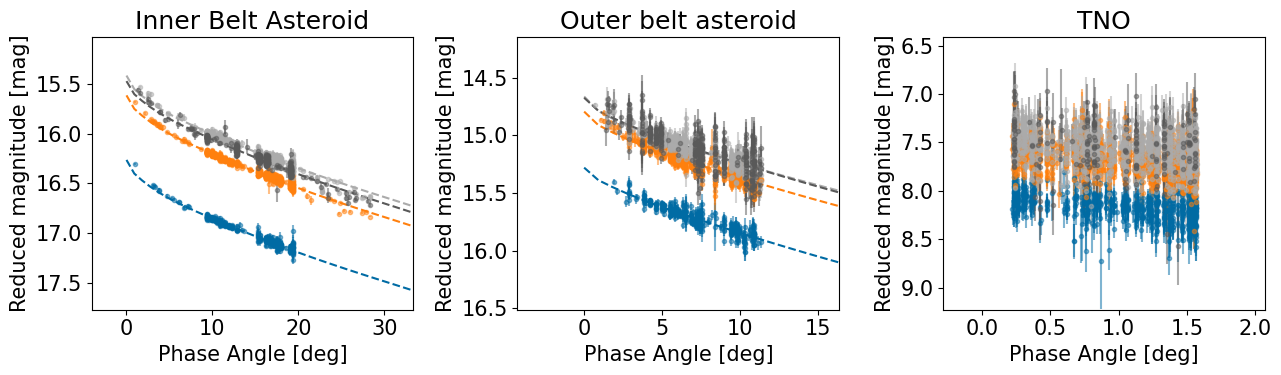

In [32]:
plt.figure(figsize=(13, 4))

# Inner Belt Asteriod
plt.subplot(131)
for i, ifilt in enumerate(filts):
    idx = df_tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='.', color=colors[i],
                 alpha=0.5, label='DP0.3 data in %s' % ifilt)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj],
                           df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj]])
    plt.plot(phases, HG12_mag, color=colors[i], linestyle='--',
             label='HG12 2-parameter model in %s' % ifilt)


plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('Inner Belt Asteroid')

# Outer Belt Asteroid
plt.subplot(132)

iObj = 2  
sId = df_uniqueObj['ssObjectId'][good_outer_belt][iObj]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filts):
    idx = df_tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='.', color=colors[i],
                 alpha=0.5, label='DP0.3 data in %s' % ifilt)

    # Plot HG12 model
    HG12_mag = HG12_model(np.deg2rad(phases),
                          [df_uniqueObj[ifilt+'_H'][good_outer_belt][iObj],
                           df_uniqueObj[ifilt+'_G12'][good_outer_belt][iObj]])
    plt.plot(phases, HG12_mag, color=colors[i], linestyle='--',
             label='HG12 2-parameter model in %s' % ifilt)


plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('Outer belt asteroid')

# TNO
plt.subplot(133)
iObj = 3  
sId = df_uniqueObj['ssObjectId'][good_TNO][iObj]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]

for i, ifilt in enumerate(filts):
    idx = df_tmp['band'] == ifilt

    # Plot observations
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='.', color=colors[i],
                 alpha=0.5)

#print(df_uniqueObj[ifilt+'_H'][good_TNO])
plt.xlim(df_tmp['phaseAngle'].min()-.5, df_tmp['phaseAngle'].max()+.5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)
plt.title('TNO')

plt.tight_layout()


Notice that the the phase coverage of objects at different semi-major axes are dramatically different over the 10-years of LSST. The most distant (>30 au) TNO will cover at most ~0-3 degrees in phase, while asteroids in the main belt will typically achieve between 0-30 degrees in terms of phase coverage. None of the "good" TNOs that we selected (even with thousands of observations) have more than 5 degrees of phase coverage. The LSST pipeline will only attempt to fit phase curves to things with more than 5 degrees of phase coverage, so the SSObject table does not include `H`, `G12` parameters for TNOs. Thus, TNOs do not have any models over-plotted. In these cases, it could be useful to independently model the phase curve using user-defined functions (e.g. for TNOs, a linear fit can be sufficient). We will explore how to explicitly model phase curves in the follow-up notebook on this topic, 03b.

### 2.5 Explore phase curve fit uncertainty in each filter

For one of the good main belt asteroids, we compare the $g$- and $z$-bands to demonstrate fit uncertainty between two filters that produce different reduced magnitude quality (mostly due to difference in brightness and therefore flux uncertainties between the filters). We compute the model phase curve for a given set of the best-fit phase curve parameters for the `HG12_model` stored in `SSObject` table, which we will call `HG12_mag_sso`. The plot shows the uncertainty in the model parameters represented by the shaded regions. Choosing fainter or less well-sampled SSObjects increases the error region.


Text(0.5, 1.0, 'ssObjectId = -8991757915344909776')

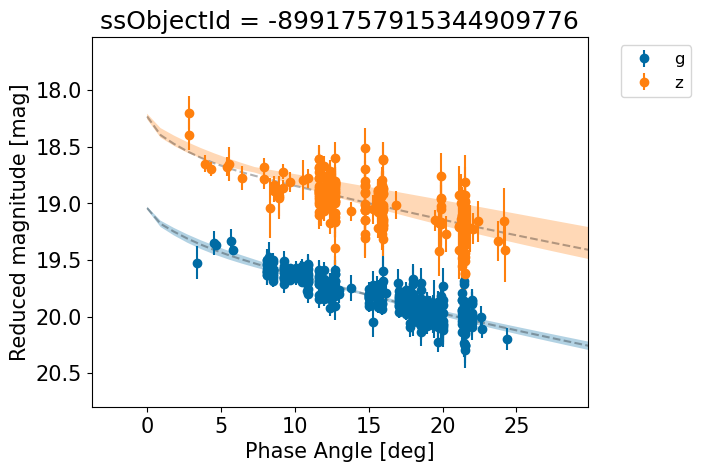

In [35]:
iObj = 2 
sId = df_uniqueObj['ssObjectId'][good_main_belt][iObj]
df_tmp = df_indivObs[df_indivObs['ssObjectId'] == sId]

for ifilt in ['g', 'z']:
    idx = df_tmp['band'] == ifilt
    plt.errorbar(df_tmp['phaseAngle'][idx], df_tmp['reducedMag'][idx],
                 yerr=df_tmp['magErr'][idx], fmt='o', label=ifilt, zorder=10)

    HG12_mag_sso = HG12_model(np.deg2rad(phases), [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj],
                                                   df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj]])
    plt.plot(phases, HG12_mag_sso, 'k--', alpha=0.3)

    # Compute min/max values in reduced mag at each phase angle
    p1 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj] + 3*df_uniqueObj[ifilt+'_Herr'][good_main_belt][iObj],
                     df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj] + 3*df_uniqueObj[ifilt+'_G12err'][good_main_belt][iObj]])

    p2 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj] - 3*df_uniqueObj[ifilt+'_Herr'][good_main_belt][iObj],
                     df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj] + 3*df_uniqueObj[ifilt+'_G12err'][good_main_belt][iObj]])

    p3 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj] + 3*df_uniqueObj[ifilt+'_Herr'][good_main_belt][iObj],
                     df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj] - 3*df_uniqueObj[ifilt+'_G12err'][good_main_belt][iObj]])

    p4 = HG12_model(np.deg2rad(phases),
                    [df_uniqueObj[ifilt+'_H'][good_main_belt][iObj] - 3*df_uniqueObj[ifilt+'_Herr'][good_main_belt][iObj],
                     df_uniqueObj[ifilt+'_G12'][good_main_belt][iObj] - 3*df_uniqueObj[ifilt+'_G12err'][good_main_belt][iObj]])

    HG_magHigh = np.maximum(np.maximum(p1, p2), np.maximum(p3, p4))
    HG_magLow = np.minimum(np.minimum(p1, p2), np.minimum(p3, p4))

    plt.fill_between(phases, HG_magLow, HG_magHigh, alpha=0.3)

plt.xlim(df_tmp['phaseAngle'].min()-5, df_tmp['phaseAngle'].max()+5)
plt.ylim(df_tmp['reducedMag'].max()+0.5, df_tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)

# 3. Exploring phase-curve data products from the DP0.3 SSObject and MPCORB catalogs 


## 3.1 Phase curve fit uncertainty vs. apparent brightness of the inner Main Belt asteroids

Here we compare the typical apparent magnitude uncertainties per filter to see how that impacts the fit. To do this, we compute the median apparent magnitude (i.e. as observed) and its median uncertainty in the $r$-band in this example. This allows us to plot phase curve parameters vs. median apparent magnitude and its median uncertainty to see how these observational characteristics impact the resulting modeling. One can see in the plot that as objects get fainter and the median apparent magnitude uncertainty increases, so does the uncertainty in the fitted parameters of the phase curve. 

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


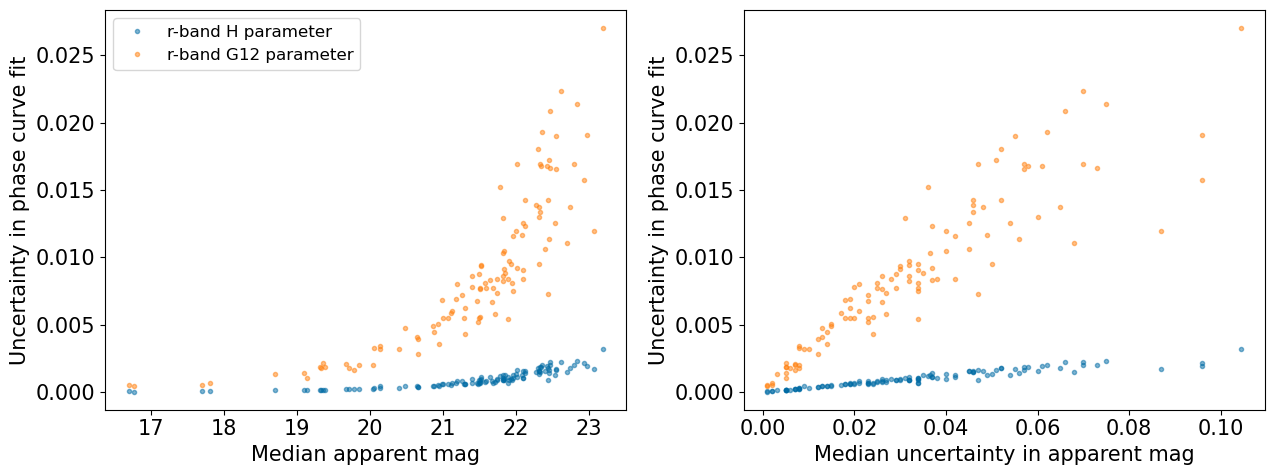

In [36]:
mag_med = []
magSigma_med = []
ifilt = 'r'

for iobj in df_uniqueObj['ssObjectId'][good_main_belt]:
    idx = df_indivObs['ssObjectId'] == iobj
    df_tmp = df_indivObs[idx]
    idx_filt = df_tmp['band'] == ifilt

    mag_med.append(np.median(df_tmp['mag'][idx_filt]))
    magSigma_med.append(np.median(df_tmp['magErr'][idx_filt]))

plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(mag_med, df_uniqueObj[ifilt+'_Herr'][good_main_belt], '.', alpha=.5,
         label=ifilt+'-band H parameter')
plt.plot(mag_med, df_uniqueObj[ifilt+'_G12err'][good_main_belt], '.', alpha=.5,
         label=ifilt+'-band G12 parameter')
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median apparent mag')
plt.legend()

plt.subplot(122)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'_Herr'][good_main_belt], '.', alpha=.5)
plt.plot(magSigma_med, df_uniqueObj[ifilt+'_G12err'][good_main_belt], '.', alpha=.5)
plt.ylabel('Uncertainty in phase curve fit')
plt.xlabel('Median uncertainty in apparent mag')

plt.tight_layout()

### 3.2 Distribution of H and G12 parameters in observed filters

First, we explore the distribution of typical values of the `G12` slope parameter as a function of absolute magnitudes. Remember that the input (truth) `G` value using the `HG_model` that was used to generate the DP0.3 simulated object's observed properties was fixed across the population to a constant value of G=0.15. The DP0.3 automated phase curve fitting (which uses `HG12_model`) produces a nearly constant value for `G12` with a relatively small spread at bright magnitudes, and the scatter in measured `G12` starts to deviate more substantially at fainter magnitudes where its likely harder to recover the intrinsic value.

Text(0.02, 0.5, 'Slope parameter, G12')

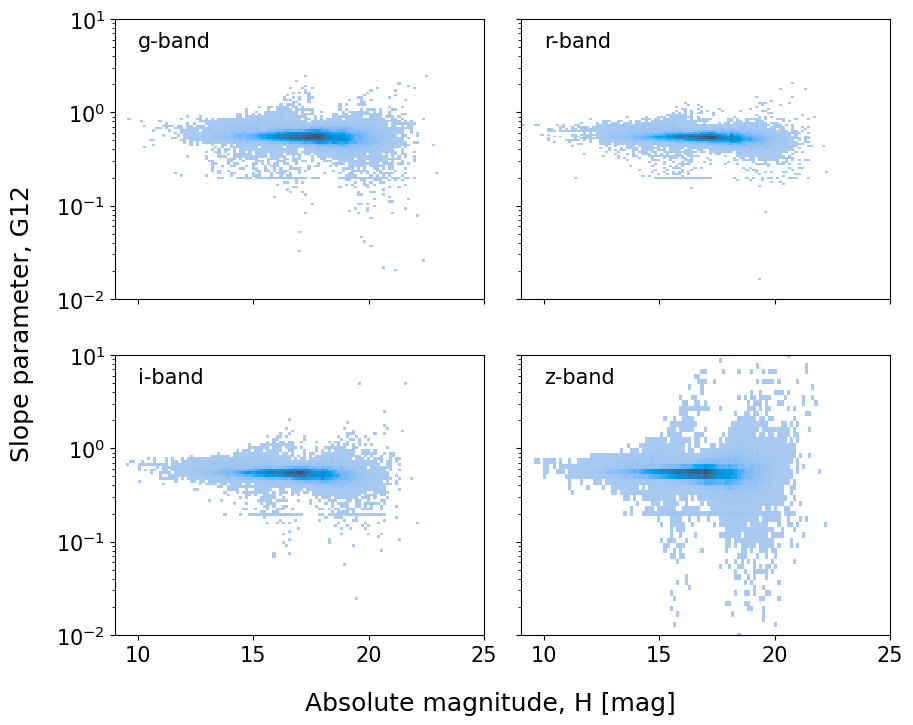

In [37]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.2)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()


for i, ifilt in enumerate(filts):
    sns.histplot(x=df_uniqueObj[ifilt+'_H'], y=df_uniqueObj[ifilt+'_G12'], bins=100,
                 log_scale=(False, True), ax=axs[i])
    axs[i].text(10, 5, ifilt+'-band')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

plt.xlim(9, 25)
plt.ylim(1e-2, 1e1)

fig.supxlabel('Absolute magnitude, H [mag]')
fig.supylabel('Slope parameter, G12')

### 3.3 How phase-curve fit quality depends on total number of LSST observations and perihelion distance

Now, we explore the impact of the total number of observations for a given source (`numObs`) and the perihelion distance (`q`) on the quality of phase curve fitting in $i$-band as an example. In the left columns, it is clear that the model uncertainties decrease with number of observations of each source. So as LSST accumulates data over time, precision in the phase curve modeling will improve. The right columns show that uncertainties in the phase-curve parameters modestly increase for objects with larger perihelion distances. 

Text(0.5, 0, 'perihelion distance [au]')

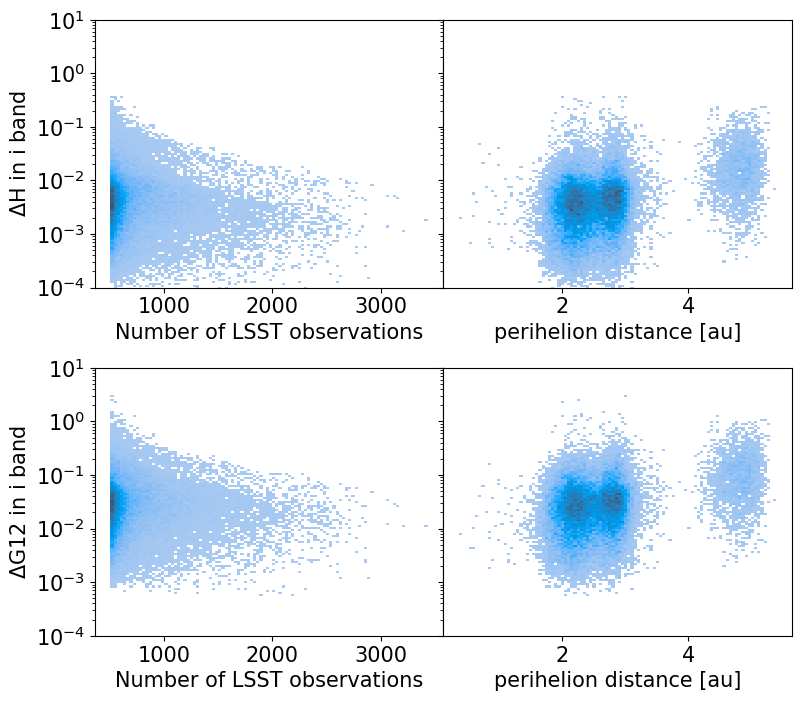

In [38]:
fig = plt.figure(figsize=(9,8))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0.3)
axs = gs.subplots(sharey=True)
ifilt = 'i'

sns.histplot(x=df_uniqueObj['numObs'], y=df_uniqueObj[ifilt+'_Herr'], bins=100,
             log_scale=(False, True), ax=axs[0, 0])
axs[0, 0].set_xlabel('Number of LSST observations')
axs[0, 0].set_ylabel('$\Delta$H in %s band' % ifilt)
plt.ylim(1e-4, 1e1)

sns.histplot(x=df_uniqueObj['q'], y=df_uniqueObj[ifilt+'_Herr'], bins=100, ax=axs[0, 1])
axs[0, 1].set_xlabel('perihelion distance [au]')

sns.histplot(x=df_uniqueObj['numObs'], y=df_uniqueObj[ifilt+'_G12err'], bins=100,
             log_scale=(False, True), ax=axs[1, 0])
axs[1, 0].set_xlabel('Number of LSST observations')
axs[1, 0].set_ylabel('$\Delta$G12 in %s band' % ifilt)

sns.histplot(x=df_uniqueObj['q'], y=df_uniqueObj[ifilt+'_G12err'], bins=100, ax=axs[1, 1])
axs[1, 1].set_xlabel('perihelion distance [au]')


### 3.4 Number of datapoints used for phase curve fitting per band

The above plots compare `numObs` (total in all bands) with model fits (per band) which may not be the ideal metric since the quality of phase curves can vary quite a bit between filters. Instead, we can look at the number of datapoints included in the phase curve modeling on a per filter basis (i.e. rNdata for the r-band in the `SSObject` table). Below, we look at the distribution of the number of observations in each filter used to model the phase curve per filter. One can see that generally, $r$- and $i$-bands produce the most data points for recovering phase curves, while $g$-band produces less and $z$-band produces the fewest. Phase curves measured in $r$- and $i$-bands will thus be better sampled. 

Thus in the second panel, one can see that poorer sampling drives higher uncertainty in `H` using $z$-band instead of $r$-band for solar system objects. 

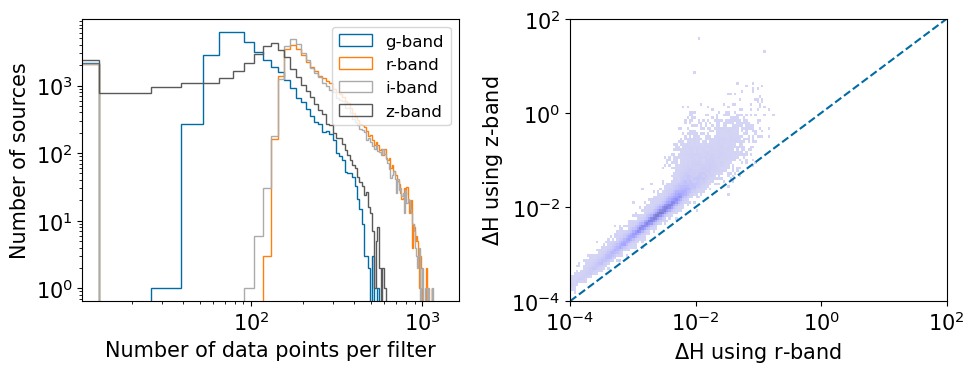

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, ifilt in enumerate(filts):
    axs[0].hist(df_uniqueObj[ifilt+'_Ndata'], bins=100, range=(0, 1300),
                histtype='step', label=ifilt+'-band')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('Number of data points per filter')
axs[0].set_ylabel('Number of sources')

sns.histplot(x=df_uniqueObj['r_Herr'], y=df_uniqueObj['z_Herr'],
             bins=100, log_scale=(True, True), color='b', ax=axs[1], alpha=0.7)

one2one = np.arange(1e-4,1000,.1)
axs[1].plot(one2one,one2one,'--')
axs[1].set_ylim(1e-4, 1e2)
axs[1].set_xlim(1e-4, 1e2)
axs[1].set_ylabel('$\Delta$H using z-band')
axs[1].set_xlabel('$\Delta$H using r-band')

plt.tight_layout()

## Summary of open questions about DP0.3: 
This DP0.3 release revealed some unknown features that we can resolve in the future as people use the simulation. Some things that warrant further exploration:

- A small bias was identified in the G parameter of `HG_model` (average measured value - intrinsic value of G of roughly 0.02).

- Offsets were found between the absolute magnitude H of each LSST filter (once correcting for color differences between LSST filters and  V filter used to define intrinsic absolute magnitude. 

## 4. Excercises for the learner

1. Explore phase curves for other types of solar system objects, e.g., Hildas and Trojan asteroids. 